# Import libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

# Data Import

In [2]:
dataset = pd.read_csv("Desktop/HR_comma_sep.csv")

##### Optional Drop Column

In [3]:
# Remove the column you want to drop
# column_to_drop = "Name"  # Replace "column_name" with the name of the column you want to remove
#dataset.drop(columns=[column_to_drop], inplace=True)

# Data Cleaning

In [4]:
dataset.info()
#Distribution
dataset.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


,count,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,3.803054,1.232592,2.00,3.00,4.00,5.00,7.0
average_montly_hours,14999.0,201.050337,49.943099,96.00,156.00,200.00,245.00,310.0
time_spend_company,14999.0,3.498233,1.460136,2.00,3.00,3.00,4.00,10.0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,1.0
left,14999.0,0.238083,0.425924,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,1.0


### Null Values

In [5]:
dataset.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

In [6]:
# Calculate the threshold for missing values
threshold = 0.2 * len(dataset)

# Iterate over each column
for column in dataset.columns:
    # Check if the column has missing values
    if dataset[column].isna().sum() > 0:
        # If the number of missing values is less than the threshold, drop rows
        if dataset[column].isna().sum() < threshold:
            dataset = dataset.dropna(subset=[column])
        # If the number of missing values is greater than or equal to the threshold, fill with mean
        else:
            dataset[column].fillna(dataset[column].mean(), inplace=True)

In [7]:
# Check for any remaining missing values
missing_values = dataset.isna().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")


## Identify Target Variable

In [8]:
target = 'left'

# Feature Engineering 

### One Hot Encoder

In [9]:
# Check for categorical variables
categorical_columns = set()

# Add columns with less than 10 unique values
for column in dataset.columns:
    if column != target and dataset[column].nunique() < 10:
        categorical_columns.add(column)

# Append columns with object data type
categorical_columns.update(dataset.select_dtypes(include=['object']).columns.tolist())

if len(categorical_columns) > 0:
    print("Categorical columns found:")
    for column in categorical_columns:
        print(column)
    
    # Fit the encoder to the categorical columns
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_columns = encoder.fit_transform(dataset[list(categorical_columns)])

    # Get the feature names from the encoder
    encoded_feature_names = encoder.get_feature_names_out(input_features=list(categorical_columns))

    # Create a DataFrame with the encoded columns and feature names
    encoded_df = pd.DataFrame(encoded_columns, columns=encoded_feature_names)

    # Drop original categorical columns
    dataset.drop(columns=categorical_columns, inplace=True)
    
    # Concatenate encoded columns with dataset
    dataset = pd.concat([dataset, encoded_df], axis=1)
    
    # Display the modified dataset
    print("Modified Dataset:")
    print(dataset.head())
else:
    print("No categorical columns found.")


Categorical columns found:
salary
number_project
promotion_last_5years
time_spend_company
Department
Work_accident
Modified Dataset:
   satisfaction_level  last_evaluation  average_montly_hours  left  \
0                0.38             0.53                   157     1   
1                0.80             0.86                   262     1   
2                0.11             0.88                   272     1   
3                0.72             0.87                   223     1   
4                0.37             0.52                   159     1   

   salary_low  salary_medium  number_project_3  number_project_4  \
0         1.0            0.0               0.0               0.0   
1         0.0            1.0               0.0               0.0   
2         0.0            1.0               0.0               0.0   
3         1.0            0.0               0.0               0.0   
4         1.0            0.0               0.0               0.0   

   number_project_5  number_project_6

### Outlier Detection

#### **Data is scaled in this step***

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Perform KMeans clustering
# Separate features (X) and target variable (y) if necessary
X = dataset.drop(columns=[target])
y = dataset[target]

# Scale the features (X)
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

kmeans = KMeans()
kmeans.fit(scaled_X)

# Get cluster centers
centers = kmeans.cluster_centers_

# Calculate distances of each point to its respective cluster center
distances = np.sqrt(np.sum((scaled_X - centers[kmeans.labels_])**2, axis=1))

# Calculate mean and standard deviation of distances
mean_distance = np.mean(distances)
std_distance = np.std(distances)

# Desired threshold as 2 standard deviations from the mean
desired_threshold = mean_distance + 1 * std_distance

# Use the threshold for outlier detection
outliers_mask = distances > desired_threshold

# Save outliers in a new dataset
outliers_dataset = dataset[outliers_mask]

# Print indices and details of outliers
print("Indices of outliers:", np.where(outliers_mask)[0])
print("Details of outliers:")
print(outliers_dataset)

# Remove outliers from the original dataset
dataset = dataset[~outliers_mask]

Indices of outliers: [    2    18    43 ... 14933 14949 14975]
Details of outliers:
       satisfaction_level  last_evaluation  average_montly_hours  left  \
2                    0.11             0.88                   272     1   
18                   0.45             0.51                   160     1   
43                   0.10             0.80                   281     1   
54                   0.10             0.92                   307     1   
56                   0.11             0.94                   255     1   
...                   ...              ...                   ...   ...   
14908                0.10             0.87                   251     1   
14929                0.10             0.83                   302     1   
14933                0.10             0.94                   264     1   
14949                0.42             0.57                   147     1   
14975                0.10             0.79                   310     1   

       salary_low  salary_m

### Binary Variables

In [11]:
binary_variables = []

# Iterate through each column
for column in dataset.columns:
    # Check if the number of unique values is 2 and values are 0 and 1, or if the value is just 0
    if (dataset[column].nunique() == 2 and set(dataset[column]) == {0, 1}) or (dataset[column].nunique() == 1 and set(dataset[column]) == {0}):
        binary_variables.append(column)

# Print binary variables
print("Binary Variables:")
print(binary_variables)

Binary Variables:
['left', 'salary_low', 'salary_medium', 'number_project_3', 'number_project_4', 'number_project_5', 'number_project_6', 'number_project_7', 'promotion_last_5years_1', 'time_spend_company_3', 'time_spend_company_4', 'time_spend_company_5', 'time_spend_company_6', 'time_spend_company_7', 'time_spend_company_8', 'time_spend_company_10', 'Department_RandD', 'Department_accounting', 'Department_hr', 'Department_management', 'Department_marketing', 'Department_product_mng', 'Department_sales', 'Department_support', 'Department_technical', 'Work_accident_1']


## Numerical to Binary Variables

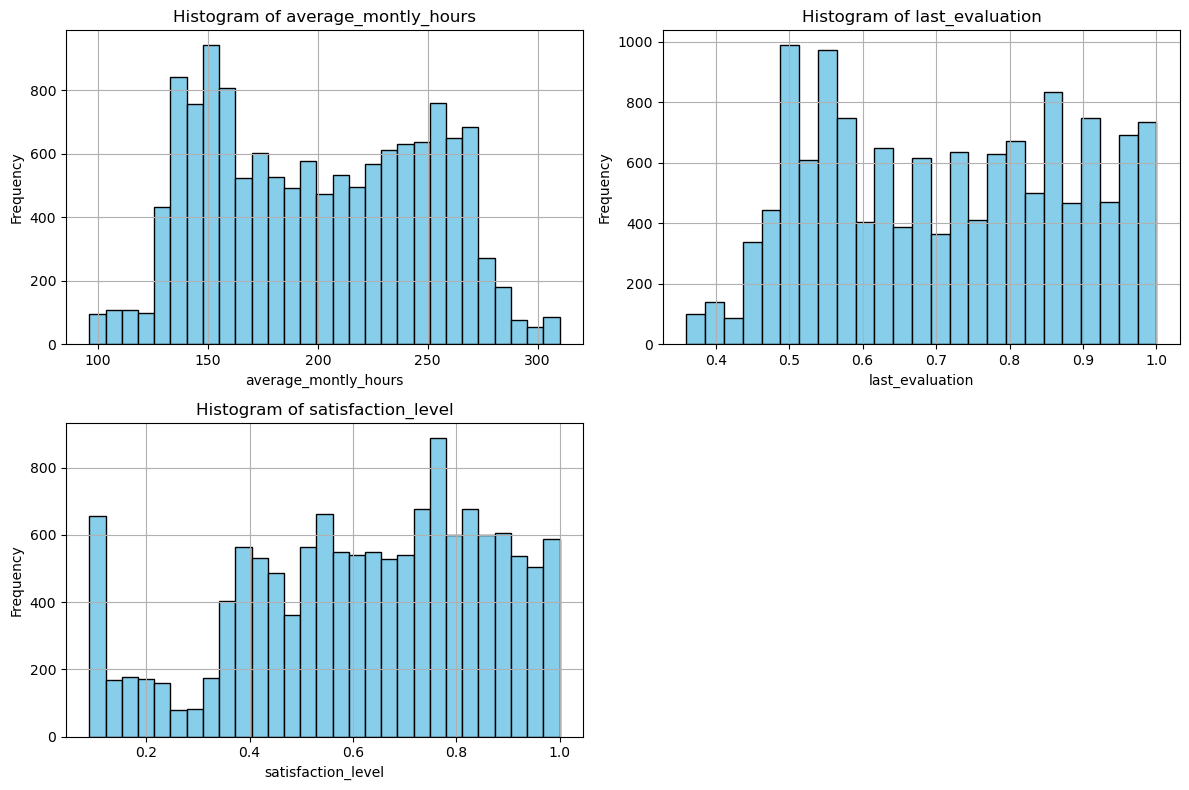

In [12]:
# Get numerical variables
numerical_variables = dataset.select_dtypes(include=['int64', 'float64']).columns
numerical_variables = numerical_variables.drop(target)
numerical_variables = numerical_variables.difference(binary_variables)

# Calculate number of bins for each numerical variable
num_bins_dict = {}
for column in numerical_variables:
    # Calculate the number of bins using Freedman-Diaconis rule
    q75, q25 = dataset[column].quantile([0.75, 0.25])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(dataset[column]) ** (1/3))
    
    # Check if bin_width is zero
    if bin_width == 0:
        # Set a default number of bins or handle it appropriately
        num_bins = 10  # Default value
    else:
        num_bins = int((dataset[column].max() - dataset[column].min()) / bin_width)
        
    # Ensure num_bins is an integer value
    num_bins = int(num_bins)
    
    num_bins_dict[column] = num_bins

# Initialize an empty DataFrame to store the binned categorical variables
binned_dataset = pd.DataFrame()

# Calculate the number of rows and columns for subplots
num_variables = len(numerical_variables)
num_rows = int(np.ceil(num_variables / 2))
num_cols = 2

# Initialize figure for histograms
plt.figure(figsize=(12, 8))

# Iterate through each numerical variable
for i, column in enumerate(numerical_variables):
    plt.subplot(num_rows, num_cols, i + 1)
    
    # Plot histogram
    plt.hist(dataset[column], bins=num_bins_dict[column], color='skyblue', edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.grid(True)
    
# Display the histograms
plt.tight_layout()
plt.show()


In [13]:
# Initialize an empty DataFrame to store the binned categorical variables
binned_dataset = pd.DataFrame()

# Iterate through each numerical variable
for column in numerical_variables:
    # Calculate the maximum number of bins for this column
    max_bins_column = num_bins_dict[column]
    
    # Bin the data accordingly
    bins, bin_edges = pd.cut(dataset[column], bins=max_bins_column, retbins=True)
    
    # Generate bin labels from the bin edges
    bin_labels = [f"{column}_{int(bin_edges[i])}_{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]
    
    # Encode bins using one-hot encoding
    encoded_bins = pd.get_dummies(bins, prefix=column)
    
    # Rename columns with integer bin edges
    encoded_bins.columns = bin_labels
    
    # Concatenate encoded bins to the binned dataset
    binned_dataset = pd.concat([binned_dataset, encoded_bins], axis=1)

# Display the first few rows of the binned dataset
print("Binned Dataset:")
print(binned_dataset.head())



Binned Dataset:
   average_montly_hours_95_103  average_montly_hours_103_110  \
0                            0                             0   
1                            0                             0   
3                            0                             0   
4                            0                             0   
5                            0                             0   

   average_montly_hours_110_118  average_montly_hours_118_125  \
0                             0                             0   
1                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   

   average_montly_hours_125_132  average_montly_hours_132_140  \
0                             0                             0   
1                             0                             0   
3            

In [14]:
# Check for duplicate column names
duplicate_columns = binned_dataset.columns[binned_dataset.columns.duplicated()]

# Print duplicate column names, if any
if len(duplicate_columns) > 0:
    print("Duplicate column names found:")
    for column in duplicate_columns:
        print(column)
    
    # Merge duplicate columns
    binned_dataset = binned_dataset.groupby(level=0, axis=1).sum()
    
    print("Duplicate columns merged.")
else:
    print("No duplicate column names found.")

Duplicate column names found:
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
last_evaluation_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
satisfaction_level_0_0
sati

In [15]:
# Drop numerical columns from the original dataset
dataset.drop(columns=numerical_variables, inplace=True)

# Concatenate binned_dataset with the original dataset
dataset = pd.concat([dataset, binned_dataset], axis=1)

# Display the updated dataset
print("Updated Dataset:")
print(dataset.head())

Updated Dataset:
   left  salary_low  salary_medium  number_project_3  number_project_4  \
0     1         1.0            0.0               0.0               0.0   
1     1         0.0            1.0               0.0               0.0   
3     1         1.0            0.0               0.0               0.0   
4     1         1.0            0.0               0.0               0.0   
5     1         1.0            0.0               0.0               0.0   

   number_project_5  number_project_6  number_project_7  \
0               0.0               0.0               0.0   
1               1.0               0.0               0.0   
3               1.0               0.0               0.0   
4               0.0               0.0               0.0   
5               0.0               0.0               0.0   

   promotion_last_5years_1  time_spend_company_3  ...  \
0                      0.0                   1.0  ...   
1                      0.0                   0.0  ...   
3           

In [16]:
# Check for any remaining missing values
missing_values = dataset.isna().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")

### Up-Sampling

##### Outcome

In [17]:
dataset.groupby(target).count()

,salary_low,salary_medium,number_project_3,number_project_4,number_project_5,number_project_6,number_project_7,promotion_last_5years_1,time_spend_company_3,time_spend_company_4,...,average_montly_hours_273_280,average_montly_hours_280_287,average_montly_hours_287_295,average_montly_hours_295_302,average_montly_hours_302_310,average_montly_hours_95_103,last_evaluation_0_0,last_evaluation_0_1,satisfaction_level_0_0,satisfaction_level_0_1
left,,,,,,,,,,,,,,,,,,,,,
0,10361,10361,10361,10361,10361,10361,10361,10361,10361,10361,...,10361,10361,10361,10361,10361,10361,10361,10361,10361,10361
1,3260,3260,3260,3260,3260,3260,3260,3260,3260,3260,...,3260,3260,3260,3260,3260,3260,3260,3260,3260,3260


Target Value Counts (Sorted):
0    10361
1     3260
Name: left, dtype: int64


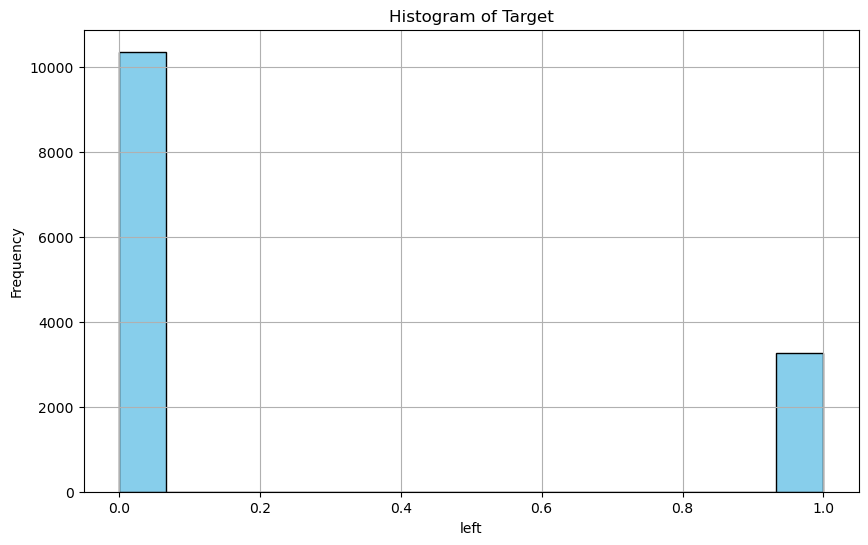

In [18]:
target_counts_sorted = dataset[target].value_counts().sort_index()

# Display the counts
print("Target Value Counts (Sorted):")
print(target_counts_sorted)

plt.figure(figsize=(10, 6))
plt.hist(dataset[target], bins='auto', color='skyblue', edgecolor='black')
plt.xlabel(target)
plt.ylabel('Frequency')
plt.title('Histogram of Target')
plt.grid(True)
plt.show()

In [19]:

df_majority = dataset[dataset[target] == 0]


df_minority = dataset[dataset[target] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),
                                 random_state=42)  # Add random_state for reproducibility

# Combine minority class with majority class
dataset = pd.concat([df_majority, df_minority_upsampled])

# Check the value counts of the prediction column in the downsampled dataset
print(dataset[target].value_counts())


0    10361
1    10361
Name: left, dtype: int64


### Bias in other features

In [ ]:
# Iterate over columns starting with "X"
for column in dataset.columns:
    if column.startswith("satisfaction"):
        # Get the target column
        upsamp_target = dataset[column]
        
        # Get the sorted value counts
        target_counts_sorted = upsamp_target.value_counts().sort_index()

        # Display the counts
        print(f"Target Value Counts for {column} (Sorted):")
        print(target_counts_sorted)

In [ ]:
# Select rows where the value in the target column is equal to 1
df_majority = dataset[dataset["sex_male"] == 1]


# Select rows where the value in the target column is equal to 0
df_minority = dataset[dataset["sex_male"] == 0]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),
                                 random_state=42)  # Add random_state for reproducibility

# Combine minority class with majority class
dataset = pd.concat([df_majority, df_minority_upsampled])

# Check the value counts of the prediction column in the downsampled dataset
print(dataset["sex_male"].value_counts())

# Dimensionality Reduction

In [20]:
#Check for perfect multicollinearity
correlation_matrix = dataset.corr()
highly_correlated_variables = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_variables.add(colname_i)
            highly_correlated_variables.add(colname_j)
print("Highly correlated variables:", highly_correlated_variables)

# Step 2: Remove constant variables
constant_variables = [col for col in dataset.columns if dataset[col].nunique() == 1]
print("Constant variables:", constant_variables)
dataset.drop(columns=constant_variables, inplace=True)

# Define the target variable 'y'
y = dataset[target]

# Select all other columns as features 'x'
x = dataset.drop(columns=[target])

Highly correlated variables: {'satisfaction_level_0_1', 'salary_low', 'satisfaction_level_0_0', 'salary_medium', 'last_evaluation_0_1', 'last_evaluation_0_0'}
Constant variables: ['number_project_7', 'promotion_last_5years_1', 'time_spend_company_8', 'time_spend_company_10']


### Principal Component Analysis (PCA)

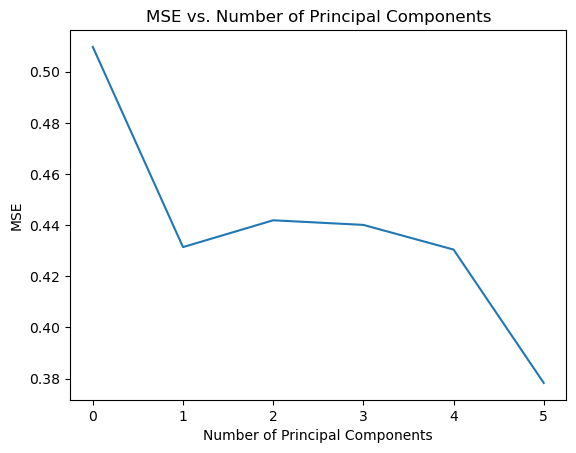

In [21]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
x_reduced = pca.fit_transform(x)

# Define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

logreg = LogisticRegression()

# Calculate MSE with only the intercept
mse = []
score = -1 * cross_val_score(logreg, np.ones((len(x_reduced), 1)), y, cv=cv, scoring='neg_mean_squared_error').mean()
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    score = -1 * cross_val_score(logreg, x_reduced[:, :i], y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)

# Plot cross-validation results
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Principal Components')
plt.show()


In [22]:
#percentage of variance in the response variable explained by adding in each principal component to the model:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 12.81,  22.87,  29.83,  36.4 ,  42.38,  47.19,  51.87,  54.88,
        57.64,  60.32,  62.7 ,  64.91,  66.93,  68.78,  70.51,  72.18,
        73.77,  75.31,  76.78,  78.23,  79.66,  81.04,  82.38,  83.7 ,
        84.97,  86.17,  87.33,  88.39,  89.32,  90.17,  90.98,  91.78,
        92.55,  93.3 ,  94.04,  94.73,  95.41,  96.07,  96.71,  97.31,
        97.8 ,  98.23,  98.56,  98.84,  99.06,  99.27,  99.45,  99.6 ,
        99.74,  99.87, 100.  , 100.  , 100.  , 100.  ])

In [23]:
# Choose the desired number of principal components based on the plot
num_components = 50  # For example, choose n principal components

# Use the selected number of principal components
x_reduced_selected = x_reduced[:, :num_components]

# Splitting the dataset

In [24]:
from sklearn.model_selection import train_test_split


# Split the data into training (50%), testing (30%), and out-of-sample (20%)
x_train, x_temp, y_train, y_temp = train_test_split(x_reduced_selected, y, test_size=0.3, random_state=100)
x_test, x_out_sample, y_test, y_out_sample = train_test_split(x_temp, y_temp, test_size=0.6, random_state=100)

In [25]:
missing_values = dataset.isnull().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")


# Fitting the Logistic Regression model

In [26]:
from sklearn.metrics import accuracy_score
# Define hyperparameters
penalty = 'l2'  # Regularization penalty ('l1' for Lasso, 'l2' for Ridge)
C = 1.0  # Inverse of regularization strength; smaller values specify stronger regularization

# Initialize logistic regression model with hyperparameters
logreg = LogisticRegression(penalty=penalty, C=C, solver='liblinear', random_state=42)

# Fit the model to the training data
logreg.fit(x_train, y_train)

# Predict on the test data
y_pred = logreg.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9304102976669348


### Optimal Threshold

In [27]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities on the test set
y_pred_proba = logreg.predict_proba(x_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Find the threshold closest to the top-left corner (maximizing TPR while minimizing FPR)
optimal_threshold_idx = np.argmax(tpr + (1 - fpr))
optimal_threshold = thresholds[optimal_threshold_idx]

# Apply the optimal threshold to classify the test data
y_pred_threshold = (y_pred_proba >= optimal_threshold).astype(int)

# Calculate accuracy using the thresholded predictions
accuracy = np.mean(y_pred_threshold == y_test)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Print the optimal threshold, AUC, and accuracy
print(f'Optimal Threshold: {optimal_threshold:.2f}')
print(f'AUC: {roc_auc:.2f}')
print(f'Accuracy: {accuracy:.2f}')


Optimal Threshold: 0.63
AUC: 0.97
Accuracy: 0.94


# Prediction of test set

In [28]:
logreg = LogisticRegression()

# Initialize and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

# Predict probabilities on the test set
y_pred_proba = logreg.predict_proba(x_test)

# Define your threshold
threshold = 0.63 # ADJUST

# Apply threshold to predicted probabilities to get predicted class labels
y_pred_threshold = (y_pred_proba[:, 1] >= threshold).astype(int)

# Calculate accuracy using thresholded predictions
accuracy = sum(y_pred_threshold == y_test) / len(y_test)
print(f'Accuracy: {accuracy}, with threshold {threshold}')

Accuracy: 0.9344328238133548, with threshold 0.63


# Actual value and the predicted value

In [29]:
logreg_diff = pd.DataFrame({'Actual value': y_test, 'Predicted probability': y_pred_proba[:, 1]})

# Calculate the predicted labels based on the threshold
logreg_diff['Predicted label'] = (logreg_diff['Predicted probability'] >= threshold).astype(int)

# Calculate the correctness based on the threshold
logreg_diff['Correct'] = (logreg_diff['Actual value'] == logreg_diff['Predicted label'])

# Display the DataFrame with the added columns
logreg_diff.head()

,Actual value,Predicted probability,Predicted label,Correct
12344,1,0.914601,1,True
4377,0,0.017755,0,True
2326,0,0.002715,0,True
1693,1,0.870148,1,True
14692,1,0.895392,1,True


# Model Evaluation

### On test data

In [30]:
from sklearn import metrics
# Predict the labels for the test set
y_pred = logreg.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred) * 100

# Print accuracy
print('Accuracy: {:.2f}%'.format(accuracy))

Accuracy: 92.96%


### On out-of-sample data

In [31]:
from sklearn.metrics import accuracy_score

# Predict the labels for the out-of-sample set
y_pred_out_sample = logreg.predict(x_out_sample)

# Calculate accuracy
accuracy_out_sample = accuracy_score(y_out_sample, y_pred_out_sample) * 100

# Print accuracy
print('Accuracy: {:.2f}%'.format(accuracy_out_sample))


Accuracy: 91.99%


# Confusion Matrix

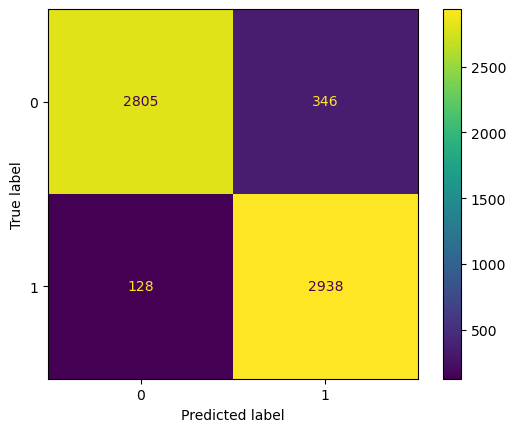

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm_test = confusion_matrix(y_test, y_pred)
cm_out_sample = confusion_matrix(y_out_sample, y_pred_out_sample)

# Combine the confusion matrices
cm = cm_test + cm_out_sample

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [33]:
# Extract indices of false positives and false negatives from the confusion matrix
false_positive_indices = [(i, j) for i in range(cm.shape[0]) for j in range(cm.shape[1]) if i != j and j == 1]  # False positive indices
false_negative_indices = [(i, j) for i in range(cm.shape[0]) for j in range(cm.shape[1]) if i != j and j == 0]  # False negative indices

# Create new DataFrame to store instances with correct and incorrect predictions
correct_rows = []
incorrect_rows = []

for index, (true_label, pred_label, out_true_label, out_pred_label) in enumerate(zip(y_test, y_pred, y_out_sample, y_pred_out_sample)):
    # Check for false positives or false negatives in the first set of predictions
    if (true_label, pred_label) in false_positive_indices or (true_label, pred_label) in false_negative_indices:
        row_data = dataset.iloc[index].tolist()
        incorrect_rows.append(row_data + [False])
    else:
        row_data = dataset.iloc[index].tolist()
        correct_rows.append(row_data + [True])

# Process remaining instances in the second set of predictions
for index, (out_true_label, out_pred_label) in enumerate(zip(y_out_sample, y_pred_out_sample)):
    # Check for false positives or false negatives in the second set of predictions
    if (out_true_label, out_pred_label) in false_positive_indices or (out_true_label, out_pred_label) in false_negative_indices:
        row_data = dataset.iloc[len(y_test) + index].tolist()  # Adjust index to start from where the first loop left off
        incorrect_rows.append(row_data + [False])
    else:
        row_data = dataset.iloc[len(y_test) + index].tolist()  # Adjust index to start from where the first loop left off
        correct_rows.append(row_data + [True])

# Create DataFrames from the collected rows
correct_df = pd.DataFrame(correct_rows, columns=dataset.columns.tolist() + ['correct'])
incorrect_df = pd.DataFrame(incorrect_rows, columns=dataset.columns.tolist() + ['correct'])

# Combine correct_df and incorrect_df into a single DataFrame
result_dataset = pd.concat([correct_df, incorrect_df], ignore_index=True)

# Print the resulting dataset
print(result_dataset)


      left  salary_low  salary_medium  number_project_3  number_project_4  \
0      0.0         1.0            0.0               0.0               1.0   
1      0.0         1.0            0.0               0.0               0.0   
2      0.0         1.0            0.0               0.0               0.0   
3      0.0         1.0            0.0               0.0               0.0   
4      0.0         1.0            0.0               1.0               0.0   
...    ...         ...            ...               ...               ...   
6212   0.0         1.0            0.0               1.0               0.0   
6213   0.0         1.0            0.0               0.0               0.0   
6214   0.0         1.0            0.0               0.0               0.0   
6215   0.0         1.0            0.0               0.0               0.0   
6216   0.0         1.0            0.0               0.0               0.0   

      number_project_5  number_project_6  time_spend_company_3  \
0        

### Fairness Test

In [34]:
# Initialize dictionary to store error rates
error_rates = {}

# Iterate over columns in the dataset
for column in result_dataset.columns:
    # Check if the column name starts with "salary"
    if column.startswith('salary'):
        # Filter rows where the current salary column equals 1
        salary_rows = result_dataset[result_dataset[column] == 1]
        # Calculate error rate for the current salary column
        error_rate = 1 - salary_rows['correct'].mean()
        # Store error rate in the dictionary
        error_rates[column] = error_rate

# Print error rates for each salary column
for column, error_rate in error_rates.items():
    print(f"Error rate for rows where {column} = 1 in result_dataset:", error_rate)


Error rate for rows where salary_low = 1 in result_dataset: 0.07192016517549893
Error rate for rows where salary_medium = 1 in result_dataset: 0.0809745610892153


# ROC Curve

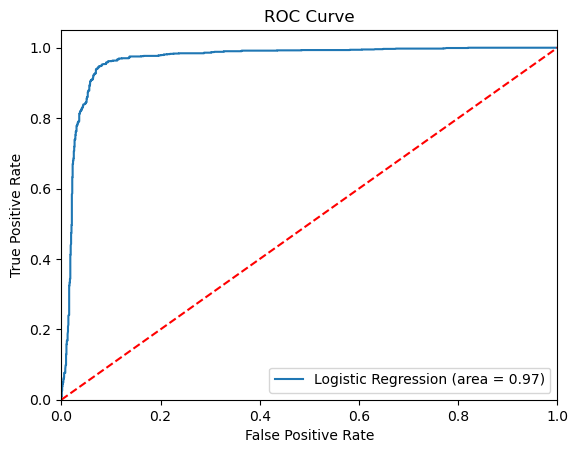

In [35]:
from sklearn.metrics import roc_curve, auc

#Predict probabilities on the test set
y_pred_proba = logreg.predict_proba(x_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Outlier Model

### Up-Sampling

Target Value Counts (Sorted):
0    1067
1     311
Name: left, dtype: int64


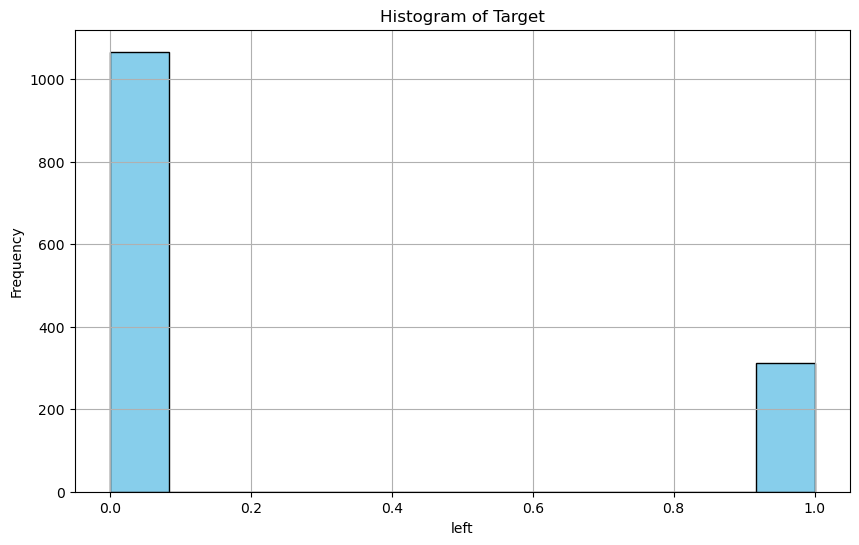

In [36]:
target_counts_sorted = outliers_dataset[target].value_counts().sort_index()

# Display the counts
print("Target Value Counts (Sorted):")
print(target_counts_sorted)

plt.figure(figsize=(10, 6))
plt.hist(outliers_dataset[target], bins='auto', color='skyblue', edgecolor='black')
plt.xlabel(target)
plt.ylabel('Frequency')
plt.title('Histogram of Target')
plt.grid(True)
plt.show()

In [37]:
df_majority = outliers_dataset[outliers_dataset[target] == 0]


df_minority = outliers_dataset[outliers_dataset[target] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),
                                 random_state=42)  # Add random_state for reproducibility

# Combine minority class with majority class
outliers_dataset = pd.concat([df_majority, df_minority_upsampled])

# Check the value counts of the prediction column in the downsampled dataset
print(outliers_dataset[target].value_counts())


0    1067
1    1067
Name: left, dtype: int64


## Dimensionality Reduction

In [38]:
#Check for perfect multicollinearity
correlation_matrix = outliers_dataset.corr()
highly_correlated_variables = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_variables.add(colname_i)
            highly_correlated_variables.add(colname_j)
print("Highly correlated variables:", highly_correlated_variables)

# Step 2: Remove constant variables
constant_variables = [col for col in outliers_dataset.columns if outliers_dataset[col].nunique() == 1]
print("Constant variables:", constant_variables)
outliers_dataset.drop(columns=constant_variables, inplace=True)

# Define the target variable 'y'
oy = outliers_dataset[target]

# Select all other columns as features 'x'
ox = outliers_dataset.drop(columns=[target])

Highly correlated variables: {'salary_medium', 'left', 'number_project_7', 'salary_low'}
Constant variables: []


### PCA

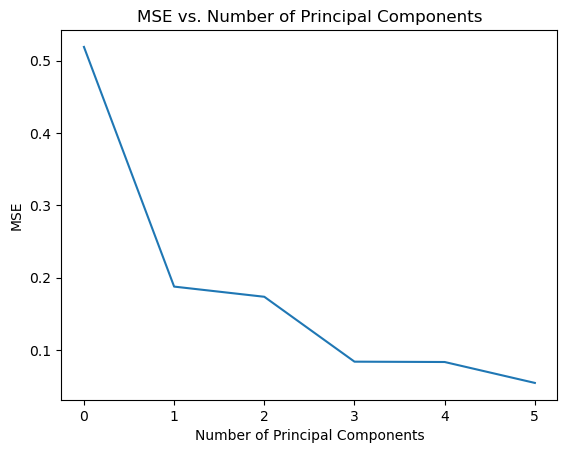

In [39]:
# Perform PCA
pca = PCA()
ox_reduced = pca.fit_transform(ox)

# Ensure both x_reduced and y have the same number of samples
min_samples = min(ox_reduced.shape[0], oy.shape[0])
ox_reduced = ox_reduced[:min_samples]
oy = oy[:min_samples]

# Define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

logreg = LogisticRegression()

# Calculate MSE with only the intercept
mse = []
score = -1 * cross_val_score(logreg, np.ones((len(ox_reduced), 1)), oy, cv=cv, scoring='neg_mean_squared_error').mean()
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    score = -1 * cross_val_score(logreg, ox_reduced[:, :i], oy, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)


# Plot cross-validation results
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Principal Components')
plt.show()


In [40]:
#percentage of variance in the response variable explained by adding in each principal component to the model:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([99.92, 99.93, 99.94, 99.95, 99.96, 99.97, 99.97, 99.97, 99.97,
       99.97, 99.97, 99.97, 99.97, 99.97, 99.97, 99.97, 99.97, 99.97,
       99.97, 99.97, 99.97, 99.97, 99.97, 99.97, 99.97, 99.97, 99.97,
       99.97])

In [41]:
# Choose the desired number of principal components based on the plot
num_components = 6  # For example, choose n principal components

# Use the selected number of principal components
ox_reduced_selected = ox_reduced[:, :num_components]

## Spliting the Outlier dataset

In [42]:
from sklearn.model_selection import train_test_split


# Split the data into training (50%), testing (30%), and out-of-sample (20%)
ox_train, ox_temp, oy_train, oy_temp = train_test_split(ox_reduced_selected, oy, test_size=0.3, random_state=100)
ox_test, ox_out_sample, oy_test, oy_out_sample = train_test_split(ox_temp, oy_temp, test_size=0.6, random_state=100)

In [43]:
missing_values = outliers_dataset.isnull().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")


## Fitting the Logistic Regression model

In [44]:
from sklearn.metrics import accuracy_score
# Define hyperparameters
penalty = 'l2'  # Regularization penalty ('l1' for Lasso, 'l2' for Ridge)
C = 1.0  # Inverse of regularization strength; smaller values specify stronger regularization

# Initialize logistic regression model with hyperparameters
logreg = LogisticRegression(penalty=penalty, C=C, solver='liblinear', random_state=42)

# Fit the model to the training data
logreg.fit(ox_train, oy_train)

# Predict on the test data
oy_pred = logreg.predict(ox_test)

# Calculate accuracy
accuracy = accuracy_score(oy_test, oy_pred)
print("Accuracy:", accuracy)

Accuracy: 0.94921875


### Optimal Threshold

In [45]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities on the test set
oy_pred_proba = logreg.predict_proba(ox_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(oy_test, oy_pred_proba)

# Find the threshold closest to the top-left corner (maximizing TPR while minimizing FPR)
optimal_threshold_idx = np.argmax(tpr + (1 - fpr))
optimal_threshold = thresholds[optimal_threshold_idx]

# Apply the optimal threshold to classify the test data
oy_pred_threshold = (oy_pred_proba >= optimal_threshold).astype(int)

# Calculate accuracy using the thresholded predictions
accuracy = np.mean(oy_pred_threshold == oy_test)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Print the optimal threshold, AUC, and accuracy
print(f'Optimal Threshold: {optimal_threshold:.2f}')
print(f'AUC: {roc_auc:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Optimal Threshold: 0.55
AUC: 0.98
Accuracy: 0.95


## Prediction of test set

In [46]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)

# Initialize and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(ox_train, oy_train)

# Predict probabilities on the test set
oy_pred_proba = logreg.predict_proba(ox_test)

# Define your threshold
threshold = 0.55 # ADJUST

# Apply threshold to predicted probabilities to get predicted class labels
oy_pred_threshold = (oy_pred_proba[:, 1] >= threshold).astype(int)

# Calculate accuracy using thresholded predictions
accuracy = sum(oy_pred_threshold == oy_test) / len(oy_test)
print(f'Accuracy: {accuracy}, with threshold {threshold}')

Accuracy: 0.94921875, with threshold 0.55


## Actual value and predicted value

In [48]:
ologreg_diff = pd.DataFrame({'Actual value': oy_test, 'Predicted probability': oy_pred_proba[:, 1]})

# Calculate the predicted labels based on the threshold
ologreg_diff['Predicted label'] = (ologreg_diff['Predicted probability'] >= threshold).astype(int)

# Calculate the correctness based on the threshold
ologreg_diff['Correct'] = (ologreg_diff['Actual value'] == ologreg_diff['Predicted label'])

# Display the DataFrame with the added columns
ologreg_diff.head()

,Actual value,Predicted probability,Predicted label,Correct
14383,1,0.989523,1,True
10872,0,0.751251,1,False
1536,1,0.987986,1,True
13840,0,0.012056,0,True
12071,1,0.552570,1,True


## Model Evaluation

### On test data

In [49]:
from sklearn import metrics
# Predict the labels for the test set
oy_pred = logreg.predict(ox_test)

# Calculate accuracy
oaccuracy = accuracy_score(oy_test, oy_pred) * 100

# Print accuracy
print('Accuracy: {:.2f}%'.format(oaccuracy))

Accuracy: 94.92%


### On out-of-sample data

In [50]:
from sklearn.metrics import accuracy_score

# Predict the labels for the out-of-sample set
oy_pred_out_sample = logreg.predict(ox_out_sample)

# Calculate accuracy
oaccuracy_out_sample = accuracy_score(oy_out_sample, oy_pred_out_sample) * 100

# Print accuracy
print('Accuracy: {:.2f}%'.format(oaccuracy_out_sample))

Accuracy: 92.21%


## Confusion Matrix

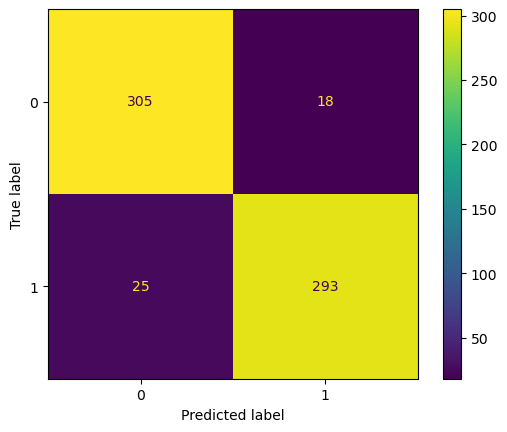

In [51]:
# Calculate the confusion matrix

ocm_test = confusion_matrix(oy_test, oy_pred)
ocm_out_sample = confusion_matrix(oy_out_sample, oy_pred_out_sample)

# Combine the confusion matrices
ocm = ocm_test + ocm_out_sample

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=ocm).plot()

In [52]:
# Extract indices of false positives and false negatives from the confusion matrix
false_positive_indices = [(i, j) for i in range(ocm.shape[0]) for j in range(ocm.shape[1]) if i != j and j == 1]  # False positive indices
false_negative_indices = [(i, j) for i in range(ocm.shape[0]) for j in range(ocm.shape[1]) if i != j and j == 0]  # False negative indices

# Create new DataFrame to store instances with correct and incorrect predictions
ocorrect_rows = []
oincorrect_rows = []

for index, (true_label, pred_label, out_true_label, out_pred_label) in enumerate(zip(oy_test, oy_pred, oy_out_sample, oy_pred_out_sample)):
    # Check for false positives or false negatives in the first set of predictions
    if (true_label, pred_label) in false_positive_indices or (true_label, pred_label) in false_negative_indices:
        row_data = outliers_dataset.iloc[index].tolist()
        oincorrect_rows.append(row_data + [False])
    else:
        row_data = outliers_dataset.iloc[index].tolist()
        ocorrect_rows.append(row_data + [True])

# Process remaining instances in the second set of predictions
for index, (out_true_label, out_pred_label) in enumerate(zip(oy_out_sample, oy_pred_out_sample)):
    # Check for false positives or false negatives in the second set of predictions
    if (out_true_label, out_pred_label) in false_positive_indices or (out_true_label, out_pred_label) in false_negative_indices:
        row_data = outliers_dataset.iloc[len(oy_test) + index].tolist()  # Adjust index to start from where the first loop left off
        oincorrect_rows.append(row_data + [False])
    else:
        row_data = outliers_dataset.iloc[len(oy_test) + index].tolist()  # Adjust index to start from where the first loop left off
        ocorrect_rows.append(row_data + [True])

# Create DataFrames from the collected rows
ocorrect_df = pd.DataFrame(ocorrect_rows, columns=outliers_dataset.columns.tolist() + ['correct'])
oincorrect_df = pd.DataFrame(oincorrect_rows, columns=outliers_dataset.columns.tolist() + ['correct'])

# Combine correct_df and incorrect_df into a single DataFrame
oresult_dataset = pd.concat([ocorrect_df, oincorrect_df], ignore_index=True)

# Print the resulting dataset
print(oresult_dataset)


     satisfaction_level  last_evaluation  average_montly_hours  left  \
0                  0.41             0.84                 191.0   0.0   
1                  0.20             0.58                 209.0   0.0   
2                  0.88             0.68                 157.0   0.0   
3                  0.70             0.69                 102.0   0.0   
4                  0.56             0.97                 163.0   0.0   
..                  ...              ...                   ...   ...   
636                0.65             0.89                 204.0   0.0   
637                0.72             0.88                 216.0   0.0   
638                0.89             0.55                 251.0   0.0   
639                0.88             0.58                 145.0   0.0   
640                0.63             0.52                 209.0   0.0   

     salary_low  salary_medium  number_project_3  number_project_4  \
0           0.0            1.0               0.0               0.

## ROC Curve

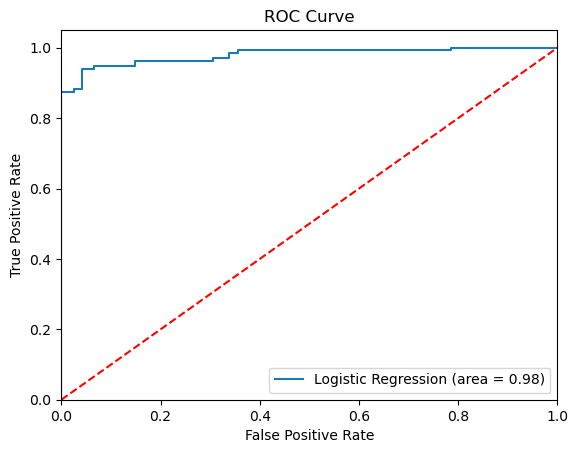

In [53]:
from sklearn.metrics import roc_curve, auc

#Predict probabilities on the test set
oy_pred_proba = logreg.predict_proba(ox_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(oy_test, oy_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Combined Model

In [54]:
combined_data = pd.concat([oresult_dataset, result_dataset], axis=0)

# Reset index after concatenation
combined_data.reset_index(drop=True, inplace=True)

# Display the combined dataset
print(combined_data)

      satisfaction_level  last_evaluation  average_montly_hours  left  \
0                   0.41             0.84                 191.0   0.0   
1                   0.20             0.58                 209.0   0.0   
2                   0.88             0.68                 157.0   0.0   
3                   0.70             0.69                 102.0   0.0   
4                   0.56             0.97                 163.0   0.0   
...                  ...              ...                   ...   ...   
6853                 NaN              NaN                   NaN   0.0   
6854                 NaN              NaN                   NaN   0.0   
6855                 NaN              NaN                   NaN   0.0   
6856                 NaN              NaN                   NaN   0.0   
6857                 NaN              NaN                   NaN   0.0   

      salary_low  salary_medium  number_project_3  number_project_4  \
0            0.0            1.0               0.0   

In [55]:
# Calculate accuracy
accuracy = combined_data['correct'].mean() * 100  # Convert to percentage

# Display accuracy
print("Accuracy:", accuracy, "%")

Accuracy: 92.46135899679206 %
